# Explanation of the Function Evaluator

In this notebook, we showcase how the function evaluator is used in `lcm`, and how it
works. Before we dive into the details, let us consider what it does on a high level.

## Motivation

Consider the last period of a finite dynamic programming problem. The value function
array for this period corresponds to the maximum of concurrent utility in each state,
where the maximum is taken over choices.

If the state-space is discretized into states $(x_1, \ldots, x_p)$, the value function
array (in the last period) $V_T$ is a $p$-dimensional array, where the $i$-th entry
$V_{T, i} = V_T(x_i)$ is the maximal utility the agent can achieve in state $x_i$.

Consider now the Bellman equation for the second-to last period:

$$
V_{T-1}(x) =
    \max_{a} \left\{u(x, a) + \mathbb{E}_{T-1}\left[V_T(x') \mid x, a\right] \right\},
$$

where $a$ denotes the action, and $x', x$ denote the next and current state,
respectively.

Depending on the solution algorithm, or the method to approximate the expectation, we
may need to evaluate the function $V_T$ at a different set of points than the
pre-calculated grid points $(x_1, \ldots, x_p)$.

Ideally, we would like to treat $V_T$ as an analytical function that can be evaluated at
any valid state $x$, ignoring the discretization. This is precisely what the function
evaluator does.
                                                        

### Example

As an example, consider a stripped down version of the deterministic model from
Iskhakov et al. (2017), which removes the absorbing retirement filter and the lagged
retirement state compared to the original model (this version can be found in the
`tests/test_models/deterministic.py` module). Here we also use a coarser grid to
showcase the behavior of the function evaluator.

In [1]:
import jax.numpy as jnp


def utility(consumption, working, disutility_of_work):
    return jnp.log(consumption) - disutility_of_work * working


def labor_income(working, wage):
    return working * wage


def working(retirement):
    return 1 - retirement


def wage(age):
    return 1 + 0.1 * age


def age(_period):
    return _period + 18


def next_wealth(wealth, consumption, labor_income, interest_rate):
    return (1 + interest_rate) * (wealth - consumption) + labor_income


def consumption_constraint(consumption, wealth):
    return consumption <= wealth


model = {
    "description": (
        "Starts from Iskhakov et al. (2017), removes filters and the lagged_retirement "
        "state, and adds a wage function that depends on age."
    ),
    "functions": {
        "utility": utility,
        "next_wealth": next_wealth,
        "consumption_constraint": consumption_constraint,
        "labor_income": labor_income,
        "working": working,
        "wage": wage,
        "age": age,
    },
    "choices": {
        "retirement": {"options": [0, 1]},
        "consumption": {
            "grid_type": "linspace",
            "start": 1,
            "stop": 400,
            "n_points": 20,
        },
    },
    "states": {
        "wealth": {
            "grid_type": "linspace",
            "start": 1,
            "stop": 400,
            "n_points": 10,
        },
    },
    "n_periods": 2,
}


params = {
    "beta": 0.95,
    "utility": {"disutility_of_work": 0.25},
    "next_wealth": {
        "interest_rate": 0.05,
    },
}

To generate the correct JAX grids from this model specification, we process the
model manually. This is normally done under the hood in `lcm`.

In [2]:
from lcm.process_model import process_model

processed_model = process_model(model)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


#### Last period value function array

To compute the value function array in the last period, we first generate the utility
and feasibility function that depends only on state and action variables, and then
compute the maximum over all feasible actions.

In [3]:
from lcm.model_functions import get_current_u_and_f

u_and_f = get_current_u_and_f(processed_model)

u_and_f.__signature__

<Signature (consumption, params, retirement, wealth)>

We can then evaluate `u_and_f` on scalar values. Notice that in the below example, the
action is not feasible since the consumption constraint forbids a consumption level that
is larger than wealth.

In [4]:
_u, _f = u_and_f(
    consumption=100,
    retirement=0,
    wealth=50,
    params=params,
)

print(f"Utility: {_u}, feasible: {_f}")

Utility: 4.355170249938965, feasible: False


To evaluate `u_and_f` on the whole state-choice-space we need to use `lcm.productmap`,
which allows us to pass in grids for each variable.

In [5]:
processed_model.grids.keys()

dict_keys(['retirement', 'wealth', 'consumption'])

In [6]:
from lcm.dispatchers import productmap

u_and_f_mapped = productmap(u_and_f, variables=["wealth", "consumption", "retirement"])

u, f = u_and_f_mapped(**processed_model.grids, params=params)

print(f"Length of (wealth, consumption, retirement) grids: {u.shape}")

Length of (wealth, consumption, retirement) grids: (10, 20, 2)


Now we can compute the value function array by taking the maximal utility over all
feasible actions (axis 1 and 2 correspond to the consumption and retirement dimensions
respectively).

In [7]:
vf_arr = jnp.max(u, axis=(1, 2), where=f, initial=-jnp.inf)
vf_arr.shape

(10,)

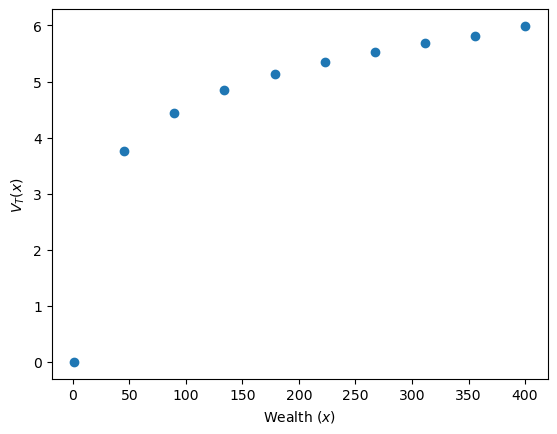

In [8]:
import matplotlib.pyplot as plt

wealth_grid = processed_model.grids["wealth"]

plt.scatter(wealth_grid, vf_arr)
plt.xlabel("Wealth ($x$)")
plt.ylabel("$V_T(x)$")
plt.show()

#### Interpolation

What happens now if we want to know the value of $V_T$ at 25 or 75.__signature__ We need to perform
some kind of interpolation. This is where the function evaluator comes into play, which
returns pre-calculated values if evaluated on a grid point, and linearly interpolated
values otherwise.

To optimally utilize the structure of the grids when interpolating, the function
evaluator requires information on the state space.

In [9]:
from lcm.state_space import create_state_choice_space

# the space info object contains information on the grid structure etc.
space_info = create_state_choice_space(
    model=processed_model,
    period=1,
    is_last_period=True,
    jit_filter=False,
)[1]

#### Setting up the function evaluator

The first step is to generate a function that can interpolate on the value function
array. The resulting function can be called with scalar arguments (here this means we
can only pass scalar levels of wealth and no grids). It also requires the grid on
which it interpolates as an argument. The name of this argument can be set using the
`data_name` argument. Below we use `data_name="vf_arr"`, which implies that the
resulting function gets an additional argument `vf_arr` that can be used to pass in the
pre-calculated value function array.

In [10]:
from lcm.function_evaluator import get_function_evaluator

scalar_value_function = get_function_evaluator(
    space_info=space_info,
    data_name="vf_arr",
)
scalar_value_function.__signature__

<Signature (vf_arr, wealth)>

We then apply the productmap decorator, which allows us to evaluate the function on a
grid of state variables (in this case, just wealth).

In [11]:
value_function = productmap(scalar_value_function, variables=["wealth"])

#### Visualizing the results

Besides the pre-calculated values at the grid points, we will now add the values
generated by evaluating the value function on the original grid points, and on
additional points computed by the value function generated by the function evaluator.
We expect the values on the grid points to coincide, and the values on the additional
points to be interpolated.

In [12]:
wealth_grid = processed_model.grids["wealth"]
wealth_points_new = jnp.array([10, 25, 75, 210, 300])

vf_on_grid = value_function(wealth=wealth_grid, vf_arr=vf_arr)
vf_on_new_values = value_function(wealth=wealth_points_new, vf_arr=vf_arr)

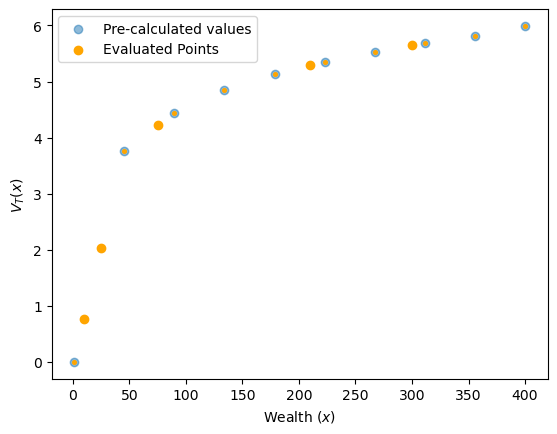

In [13]:
plt.scatter(wealth_grid, vf_arr, alpha=0.5, zorder=-1, label="Pre-calculated values")
plt.scatter(wealth_grid, vf_on_grid, color="orange", s=7)
plt.scatter(
    wealth_points_new,
    vf_on_new_values,
    color="orange",
    label="Evaluated Points",
)
plt.xlabel("Wealth ($x$)")
plt.ylabel("$V_T(x)$")
plt.legend()
plt.show()

If we now connect the pre-calculated values at the grid points using a line, that is,
we perform a linear interpolation on the value function array. We see that the values
generated by the function evaluator lie on that linear interpolation line.

That means, the function evaluator can simply be thought of as a function that behaves
like an analytical function corresponding to this linear interpolation.

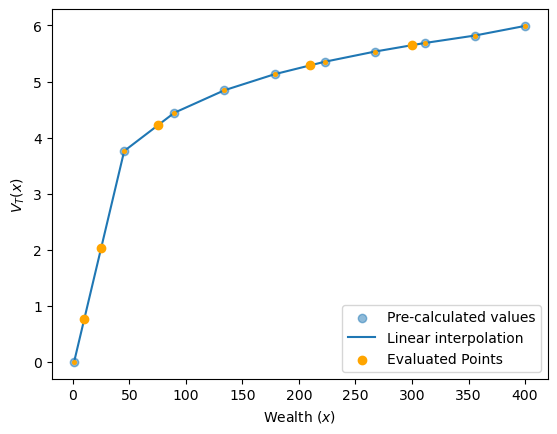

In [14]:
plt.scatter(wealth_grid, vf_arr, alpha=0.5, zorder=-1, label="Pre-calculated values")
plt.plot(
    wealth_grid,
    vf_arr,
    zorder=-1,
    label="Linear interpolation",
)
plt.scatter(wealth_grid, vf_on_grid, color="orange", s=7)
plt.scatter(
    wealth_points_new,
    vf_on_new_values,
    color="orange",
    label="Evaluated Points",
)
plt.xlabel("Wealth ($x$)")
plt.ylabel("$V_T(x)$")
plt.legend()
plt.show()

## Technical Details

In the following, we will discuss the building blocks that are used to implement the
function evaluator.

### Label Translator

The label translator is used to map the labels of dense discrete grids to their
corresponding index in the grid. Currently, `lcm` works under the assumption that
internal discrete grids always correspond to their indices. That is, a grid like [2, 3]
is not allowed, but would have to be represented as [0, 1] to be valid.
       
(Once issue [#82](https://github.com/OpenSourceEconomics/lcm/issues/82) is tackled, )
LCM converts discrete grids into an internal grid that is directly usable as an index.
Thus, the label translator simply is the identity function.

In [15]:
from lcm.function_evaluator import _get_label_translator

translator = _get_label_translator(in_name="health")
translator.__signature__

<Signature (health)>

In [16]:
translator(health=3)

3

### Lookup Function

The lookup function emulates indexing into an array via named axes.

> Note. These helper functions are important because we use `dags.concatenate_functions`
> to combine all auxiliary functions to get the final function evaluator.

In [17]:
# We want a function that allows us to perform a lookup like this:
vf_arr[jnp.array([0, 2, 5])]

Array([0.       , 4.4426513, 5.351858 ], dtype=float32)

In [18]:
from lcm.function_evaluator import _get_lookup_function

lookup = _get_lookup_function(array_name="vf_arr", axis_names=["wealth_index"])
lookup.__signature__

<Signature (wealth_index, vf_arr)>

In [19]:
lookup(wealth_index=jnp.array([0, 2, 5]), vf_arr=vf_arr)

Array([0.       , 4.4426513, 5.351858 ], dtype=float32)

### Coordinate Finder

For continuous grids (linearly and logarithmically spaced), the coordinate finder
returns the *general* index corresponding to the given value. As an example, consider a
linearly spaced grid [1, 2, 3]. The general coordinate value given the value 1.5 is, in
this case, 0.5, because 1.5 is exactly in the middle between 1 (index = 0) and 2 (index =
1). The output of the coordinate finder can then be used by
`jax.scipy.ndimage.map_coordinates` for the interpolation.

In [20]:
from lcm.interfaces import ContinuousGridInfo

wealth_grid_info = ContinuousGridInfo(start=1, stop=400, n_points=10)

# Assuming a linear spacing, grid_info correponds to the following grid:
jnp.linspace(1, 400, 10)

Array([  1.      ,  45.333336,  89.66667 , 134.00002 , 178.33334 ,
       222.66667 , 267.00003 , 311.33334 , 355.6667  , 400.      ],      dtype=float32)

In [21]:
from lcm.function_evaluator import _get_coordinate_finder

wealth_coordinate_finder = _get_coordinate_finder(
    in_name="wealth",
    grid_type="linspace",
    grid_info=wealth_grid_info,
)
wealth_coordinate_finder.__signature__

<Signature (wealth)>

To showcase the behavior of the coordinate finder, and how the *general* indices work,
consider the following wealth values:

- **1:** This value is the first value in the original grid, therefore the index must
  correspond to 0
- **(1 + 45.333336) / 2:** This value is exactly in the middle between the first and second
  value in grid, therefore the general index corresponds (0 + 1) / 2 = 0.5
- **395:** This value is very close to the last index in the original grid, so the general
  index will be very close to 9.

In [22]:
wealth_values = jnp.array([1, (1 + 45.333336) / 2, 390])

wealth_coordinate_finder(wealth=wealth_values)

Array([0.        , 0.50000006, 8.774436  ], dtype=float32)

### Interpolator

In [23]:
from lcm.function_evaluator import _get_interpolator

value_function_interpolator = _get_interpolator(
    data_name="vf_arr",
    axis_names=["wealth_index"],
    map_coordinates_options=None,
)
value_function_interpolator.__signature__

<Signature (vf_arr, wealth_index)>

In [24]:
wealth_indices = wealth_coordinate_finder(wealth=wealth_values)

vf_interpolations = value_function_interpolator(
    wealth_index=wealth_indices,
    vf_arr=vf_arr,
)
vf_interpolations

Array([0.       , 1.8806003, 5.952807 ], dtype=float32)

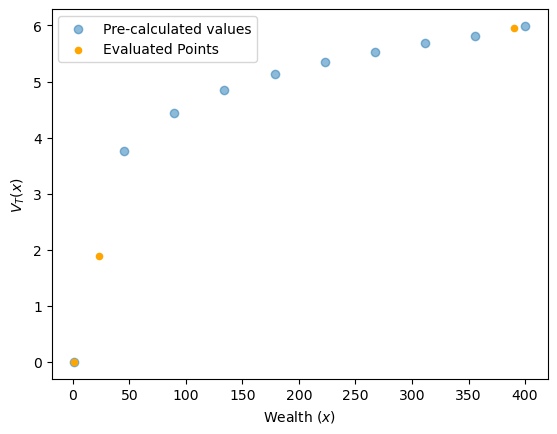

In [25]:
plt.scatter(wealth_grid, vf_arr, alpha=0.5, zorder=-1, label="Pre-calculated values")
plt.scatter(
    wealth_values,
    vf_interpolations,
    color="orange",
    s=20,
    label="Evaluated Points",
)
plt.xlabel("Wealth ($x$)")
plt.ylabel("$V_T(x)$")
plt.legend()
plt.show()

## Re-implementation of the function evaluator given the example model

Next, we will outline and implement the steps to re-implement the function evaluator for
the example model specified above. This is intended to help with understanding how the
internals of the function evaluator work.

### The Steps

We start by listing the required steps. The general idea is to generate functions for
the array lookup, interpolation, and so on, with the correct signature signaling their
dependence structure. These can then be combined into a single function that performs
all necessary steps using `dags.concatenate_functions`.


1. Add functions to look up positions of discrete state variables given their labels

   In the above example model there are no discrete state variables, so we can skip this
   step. If there are discrete variables, the lookup functions will coincide with the
   identity function, as the variables themselves are indices.


1. Wrap indexers and put them into functions

   Indexers help with processing sparse state variables, i.e., variables that have
   filters acting upon them. In the above example model there are no filters, and thus,
   also no indexers. In the general case, we would have to generate lookup functions for
   each indexer.


1. Create the lookup function for the discrete part

   In this step, a function is generated that allows one to index into the
   pre-calculated value function array using the labels of the sparse and dicrete
   state variables. In the above example model, there are no discrete state variables,
   so this function returns the value function array untouched.


1. Create interpolation functions for the continuous state variables

   If the model contains (dense) continuous state variables, interpolation functions
   are required.

   1. Add a coordinate finder for each continuous state variable
      
      This allows us to map values of the continuous variable into their corresponding
      (general) indices, as required by the interpolator.

   1. Add an interpolator

      The interpolator uses the general indices from the last step, to interpolate on
      the values of the state variable at the corresponding grid points.


1. Throwing everything into dags

  The last step is to throw everything into `dags.concatenate_functions`. The resulting
  function is a value function that behaves like an analytical function.

### The Implementation

In [26]:
# Create the functions dictionary that will be passed to `dags.concatenate_functions`
funcs = {}


# Step 1: Since there are no discrete state variables the lookup info is empty, and we
# do not require any label translator
space_info.lookup_info

{}

In [27]:
# Step 2: Since there are no filters, and thus no sparse states, the indexer info is
# empty, and we do not require any lookup functions for them
space_info.indexer_infos

[]

In [28]:
# Step 3: Since there are no discrete state variables in the model, the discrete
# lookup coincides with the identity function. Since there are continuous state
# variables in the model, we must interpolate and the data that is returned here is
# used as interpolation data.


def discrete_lookup(vf_arr):
    return vf_arr


# if there was no interpolation, the entry in the funcs dictionary would have to be
# '__fval__'.
funcs["__interpolation_data__"] = discrete_lookup

In [29]:
# Step 4: (1) First we need to add a coordinate finder for the wealth state variable
from lcm.grids import get_linspace_coordinate


def wealth_coordinate_finder(wealth):
    return get_linspace_coordinate(
        wealth,
        start=1,
        stop=400,
        n_points=10,
    )


funcs["__wealth_coord__"] = wealth_coordinate_finder

In [30]:
# Step 4: (2) And second, we need to add an interpolator for the value function that
# uses the wealth coordinate finder as an input.

from jax.scipy.ndimage import map_coordinates


def interpolator(__interpolation_data__, __wealth_coord__):
    coordinates = jnp.array([__wealth_coord__])
    return map_coordinates(
        __interpolation_data__,
        coordinates=coordinates,
        order=1,
        mode="nearest",
    )


funcs["__fval__"] = interpolator

In [31]:
# Step 5: Throwing everything into dags
from dags import concatenate_functions

value_function = concatenate_functions(
    functions=funcs,
    targets="__fval__",
)
value_function.__signature__

<Signature (vf_arr, wealth)>

In [32]:
vf_evaluated = value_function(wealth=wealth_grid, vf_arr=vf_arr)

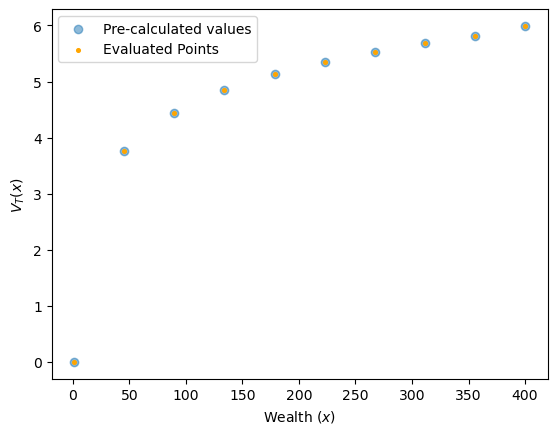

In [33]:
plt.scatter(wealth_grid, vf_arr, alpha=0.5, zorder=-1, label="Pre-calculated values")
plt.scatter(wealth_grid, vf_evaluated, color="orange", s=7, label="Evaluated Points")
plt.xlabel("Wealth ($x$)")
plt.ylabel("$V_T(x)$")
plt.legend()
plt.show()